
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [ ]:
## library imports here
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [ ]:
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output,cp_is_3,cp_is_2,cp_is_1,cp_is_0
0,63,1,3,145,233,0,150,1,1,0,0,0
1,37,1,2,130,250,1,187,1,0,1,0,0
2,56,1,1,120,236,1,178,1,0,0,1,0
3,57,0,0,120,354,1,163,1,0,0,0,1
4,57,1,0,140,192,1,148,1,0,0,0,1


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [ ]:

# Define features (X) and target (y)
X = ha.drop(columns=['output', 'cp'])
y = ha['cp']



In [ ]:
knn_pipeline = Pipeline([
    ("preprocessor", ct),
    ("knn", KNeighborsClassifier())
])

knn = knn_pipeline.fit(X,y)

y_pred_knn = knn.predict(ha.drop(columns=['output', 'cp']))
conf_matrix_knn = confusion_matrix(ha["output"], y_pred_knn)
print(conf_matrix_knn)


[[94  8 18  7]
 [34 36 63 13]
 [ 0  0  0  0]
 [ 0  0  0  0]]


In [ ]:
# Decision Tree Pipeline
tree_pipeline = Pipeline([
    ("preprocessor", ct),
    ("tree", DecisionTreeClassifier())
])

tree = tree_pipeline.fit(X, y)

y_pred_tree = tree.predict(ha.drop(columns=['output', 'cp']))
conf_matrix_tree = confusion_matrix(ha["output"], y_pred_tree)
print(conf_matrix_tree)

[[94  8 18  7]
 [34 36 63 13]
 [ 0  0  0  0]
 [ 0  0  0  0]]


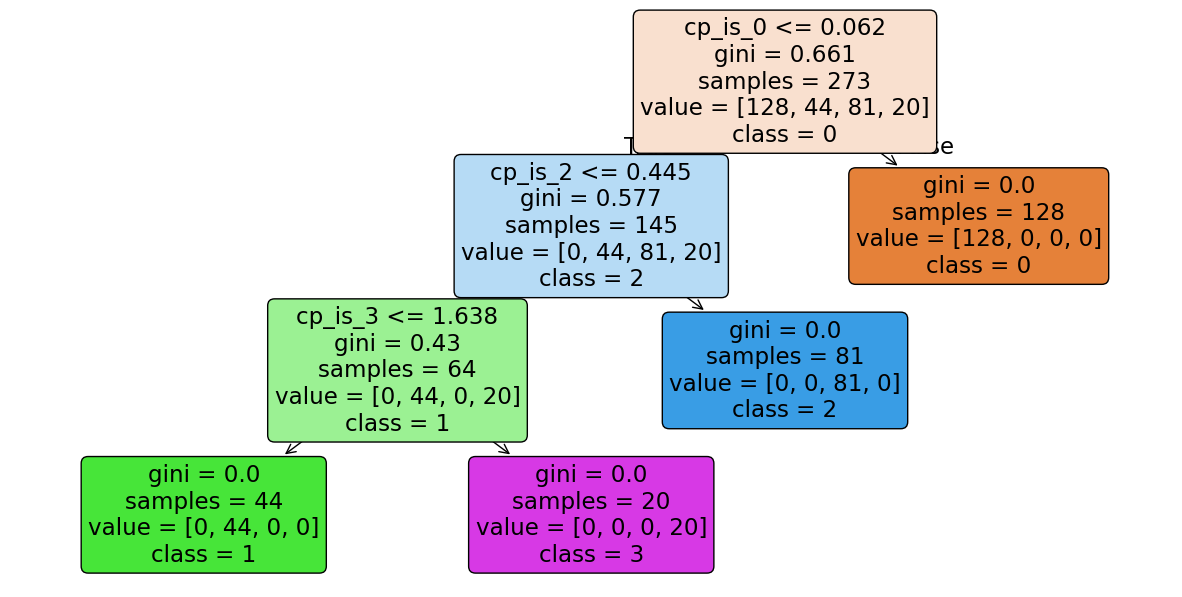

In [ ]:
# prompt: display the decision tree

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7.5))
plot_tree(tree['tree'],
          feature_names = list(X.columns),
          class_names = np.unique(y).astype('str'),
          filled=True,
          rounded=True)
plt.show()

In [ ]:
lda_pipeline = Pipeline([
    ("preprocessor", ct),
    ("lda", LinearDiscriminantAnalysis())
])

lda = lda_pipeline.fit(X, y)

y_pred_lda = lda.predict(X)
conf_matrix_lda = confusion_matrix(y, y_pred_lda)
conf_matrix_lda

array([[128,   0,   0,   0],
       [  0,  44,   0,   0],
       [  0,   0,  81,   0],
       [  0,   0,   0,  20]])

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [ ]:
# prompt: Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

# Create the new column 'cp_is_3'
ha['cp_is_3'] = (ha['cp'] == 3).astype(int)

# Create the new column 'cp_is_2'
ha['cp_is_2'] = (ha['cp'] == 2).astype(int)

# Create the new column 'cp_is_1'
ha['cp_is_1'] = (ha['cp'] == 1).astype(int)

# Create the new column 'cp_is_0'
ha['cp_is_0'] = (ha['cp'] == 0).astype(int)

In [ ]:
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

logreg_pipeline = Pipeline([
    ("preprocessor", ct),
    ("logreg", LogisticRegression(max_iter=1000))
])

In [ ]:
X = ha.drop(columns=['output', 'cp', 'cp_is_2', 'cp_is_1', 'cp_is_0', 'cp_is_3'])
y = ha['cp_is_3']

scores = cross_val_score(log_reg, X, y, cv=5, scoring='f1')
print("Mean F1-Score:", scores.mean())

Mean F1-Score: 0.0


In [ ]:
X = ha.drop(columns=['output', 'cp', 'cp_is_3', 'cp_is_1', 'cp_is_0', 'cp_is_2'])
y = ha['cp_is_2']

#log_reg = logreg_pipeline.fit(X, y)
#y_pred_logreg = log_reg.predict(ha.drop(columns=['output', 'cp', 'cp_is_3', 'cp_is_1', 'cp_is_0']))
#print("F1-Score for cp is 2:", f1_score(ha["output"], y_pred_logreg))

scores = cross_val_score(log_reg, X, y, cv=5, scoring='f1')
print("Mean F1-Score:", scores.mean())

Mean F1-Score: 0.08518518518518517


In [ ]:
X = ha.drop(columns=['output', 'cp', 'cp_is_3', 'cp_is_2', 'cp_is_0', 'cp_is_1'])
y = ha['cp_is_1']

#log_reg = logreg_pipeline.fit(X, y)
#y_pred_logreg = log_reg.predict(ha.drop(columns=['output', 'cp', 'cp_is_3', 'cp_is_1', 'cp_is_0']))
#print("F1-Score for cp is 2:", f1_score(ha["output"], y_pred_logreg))

scores = cross_val_score(log_reg, X, y, cv=5, scoring='f1')
print("Mean F1-Score:", scores.mean())

Mean F1-Score: 0.0


In [ ]:
X = ha.drop(columns=['output', 'cp', 'cp_is_3', 'cp_is_1', 'cp_is_2', 'cp_is_0'])
y = ha['cp_is_0']

#log_reg = logreg_pipeline.fit(X, y)
#y_pred_logreg = log_reg.predict(ha.drop(columns=['output', 'cp', 'cp_is_3', 'cp_is_1', 'cp_is_0']))
#print("F1-Score for cp is 2:", f1_score(ha["output"], y_pred_logreg))

scores = cross_val_score(log_reg, X, y, cv=5, scoring='f1')
print("Mean F1-Score:", scores.mean())

Mean F1-Score: 0.5886818583289172


CP 0 is the easiest to predict, as it has the highest F1-score.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [ ]:
subset = ha[(ha['cp'] == 0) | (ha['cp'] == 1)]

X = subset.drop(columns=['output', 'cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'])
y = subset['cp']

logreg_pipeline = Pipeline([
    ("preprocessor", ct),
    ("logreg", LogisticRegression(max_iter=1000))
])

logreg = logreg_pipeline.fit(X, y)

y_pred_logreg = logreg.predict(X)

cross_val_score(logreg, X, y, cv=5, scoring='roc_auc').mean()

0.7570555555555556

In [ ]:
subset = ha[(ha['cp'] == 0) | (ha['cp'] == 2)]

X = subset.drop(columns=['output', 'cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'])
y = subset['cp']

logreg_pipeline = Pipeline([
    ("preprocessor", ct),
    ("logreg", LogisticRegression(max_iter=1000))
])

logreg = logreg_pipeline.fit(X, y)

y_pred_logreg = logreg.predict(X)

cross_val_score(logreg, X, y, cv=5, scoring='roc_auc').mean()

0.6564694570135747

In [ ]:
subset = ha[(ha['cp'] == 0) | (ha['cp'] == 3)]

X = subset.drop(columns=['output', 'cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'])
y = subset['cp']

logreg_pipeline = Pipeline([
    ("preprocessor", ct),
    ("logreg", LogisticRegression(max_iter=1000))
])

logreg = logreg_pipeline.fit(X, y)

y_pred_logreg = logreg.predict(X)

cross_val_score(logreg, X, y, cv=5, scoring='roc_auc').mean()

0.7046153846153846